# Upper Slope & Axis 75 kHz ADCP

To create various plots for either the Upper Slope or Axis ADCP velocity data.

## Imports

In [2]:
import xarray as xr
import datetime
from datetime import datetime
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import pandas as pd
import seawater as sea
from scipy.stats import chi2
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook

## Data

In [3]:
#ds = xr.open_dataset('../Data/SlopeAll/slope_all.nc')
ds = xr.open_dataset('../Data/AxisAll/axis_all.nc')
print(ds)

<xarray.Dataset>
Dimensions:    (depth: 422, latitude: 4, longitude: 4, time: 162119)
Coordinates:
  * depth      (depth) float32 336.2703 336.27032 ... 968.27594 970.27026
  * latitude   (latitude) float32 48.316517 48.3166 48.316742 48.316772
  * longitude  (longitude) float32 -126.0508 -126.05022 -126.05016 -126.050125
  * time       (time) datetime64[ns] 2012-06-02T05:07:29.999996672 ... 2018-06-22T10:52:30
Data variables:
    u          (time, depth) float32 ...
    v          (time, depth) float32 ...
    w          (time, depth) float32 ...
    temp       (time) float32 ...
Attributes:
    Conventions:                             CF-1.6
    title:                                   Ocean Networks Canada RDI ADCP Data
    institution:                             Ocean Networks Canada
    source:                                  Fixed-position Teledyne-RDI ADCP...
    history:                                 data extracted from raw output, ...
    references:                       

<IPython.core.display.Javascript object>


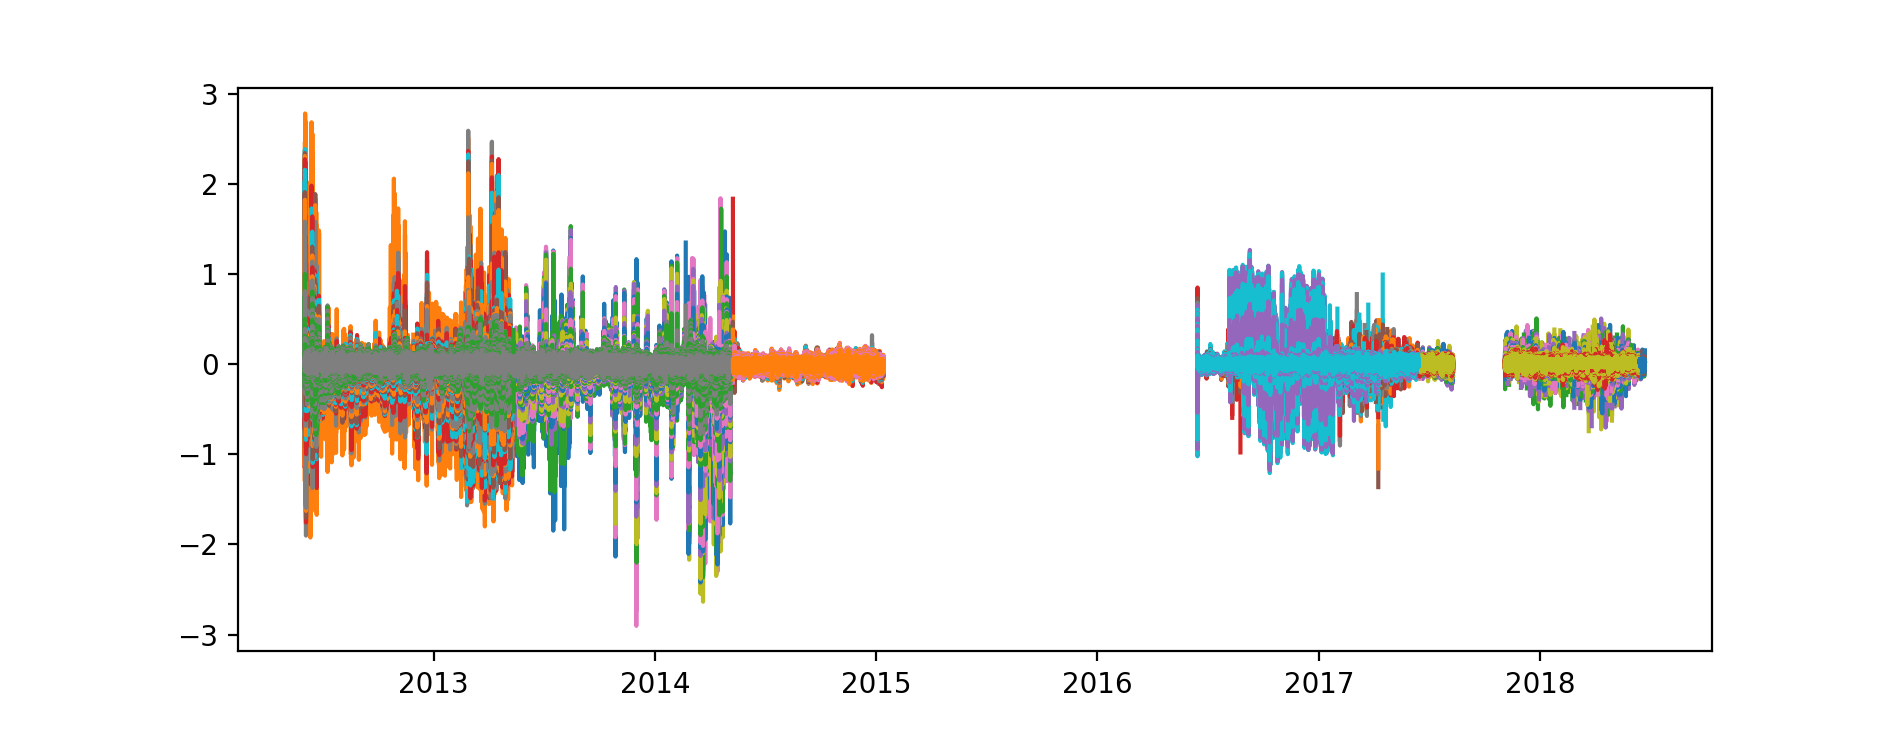

In [4]:
plt.plot(ds.time,ds.u)
plt.show()

## Depth

Truncate data to a specific depth interval to eliminate unreliable data (from visual inspection of velocity plots) from the top and bottom of the ADCP beam.

In [5]:
# function to find nearby indices for desired depth values
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx     # returns index of nearest depth value

array = ds.depth   # input array to process 
#upval = 100        # upper depth for data, metres (upper slope)
#lowval = 330       # lower depth for data (upper slope)
upval = 400        # upper depth for data, metres (axis)
lowval = 900       # lower depth for data (axis)
upidx = find_nearest(array, upval)               # index of upper depth cutoff
lowidx = find_nearest(array,lowval)+1              # index of lower depth cutoff 

print("Index at upper depth cutoff:", upidx)
print("Value at upper depth cutoff:", -ds.depth.values[upidx], "metres" )
print('---')
print("Index at lower depth cutoff:", lowidx)
print("Value at lower depth cutoff:", -ds.depth.values[lowidx], "metres" )

depth = np.array(ds.depth[upidx:lowidx+1])       # remove unwanted depths, this will be used in the next steps

print('---')
print("Length of new depth array: ", len(depth)) # new depth interval
print('Upper limit at',-depth[0],'metres')      # depth for upper PSD
print('Lower limit at',-depth[-1],'metres')       # depth for lower PSD

# depth stamps for use in output filenames
dup_stamp = int(-depth[0])
dlow_stamp = int(-depth[-1])

Index at upper depth cutoff: 48
Value at upper depth cutoff: -400.2703 metres
---
Index at lower depth cutoff: 377
Value at lower depth cutoff: -904.2703 metres
---
Length of new depth array:  330
Upper limit at -400.2703 metres
Lower limit at -904.2703 metres


## Time

Find specific time range and format dates. If significant *consecutive* NaN values are present then shorten series for that particular spectrum.

In [221]:
datestimes = pd.to_datetime(ds.time.values)        # convert to datetime from datetime64
datestimes = pd.Series(datestimes)                 # convert to pandas dataframe

start_date = pd.datetime(2013,1,1)
end_date = pd.datetime(2014,1,1)
start = datestimes[datestimes >= start_date].index[0]     # desired start date
end = datestimes[datestimes < end_date].index[-1]       # desired end date
time_total = ds.time.values[start:end]                               # total interval
print("Initial time range:",np.min(time_total),np.max(time_total))   # print to check desired interval

# check new time series for significant NaN values
depth_test = ds.depth[lowidx]     # mid-depth for ideal data (less noise, etc.)   
print('at depth',ds.depth.values[lowidx],'m')
u_test = np.array(ds.u[start:end,lowidx])        # u data at this depth
NaN_series = np.zeros(len(u_test))                   # empty array to indicate NaN values
counter = 0                                          # counter to keep track of # of consecutive NaN values
for i in range(len(time_total)):                     # loop to count consecutive NaN values
    if np.isnan(u_test[i])==True:                    # add to counter if NaN = true
        NaN_series[i] = 1
        counter += 1
        if counter==2688:                              # a consecutive month worth of NaN
            dead = i-2688                              # date time series hits significant NaN interval
            print("Time series hits trouble AFTER date:",time_total[dead])
            time_new = time_total[0:dead]            # new truncated interval
            end -= (len(time_total)-len(time_new))   # new end date 
            print("Good data time range:",np.min(time_new),np.max(time_new))
    elif np.isnan(u_test[i])==False:                 # reset counter if NaN inconsistent
        counter = 0       

# usable interval, for next steps
time = ds.time.values[start:end]    

# set year time stamp for output filenames
t_stamp = f'{datestimes.dt.year[start]}'

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


Initial time range: 2013-01-01T00:07:30.000003328 2013-12-31T23:37:30.000000000
at depth 904.2703 m


## Filters

Digital low-pass Butterworth filter to remove tides, if necessary.

In [7]:
# low pass Butterworth filter for 40 hour cut-off to remove 30 hour tides

fs = 4                # samples per HOUR for entire time series
fc = 0.025            # 40 hour low pass filter cut-off
Wn = fc / (fs / 2)    # normalised cut-off frequencies
b, a = sig.butter(8, Wn,'lowpass')  # digital butterworth filter
w, h = sig.freqz(b, a)

## Clean

Loop to acquire rotated and NaN filtered data.

Data rotated based on a visual estimate of along-slope angle, as 30$^{\circ}$. This could be updated to reflect Thomson's work at the A1 site, relatively nearby.

Data are also interpolated to deal with minor instances of NaN values. Consistent NaN intervals are dealt with in the Time section, above.

In [222]:
# rotate data
theta_along_slope = np.radians(30)                       # rotation angle in radians, 30 degrees
u_vec = ds.u[start:end,upidx:lowidx+1] + 1j*ds.v[start:end,upidx:lowidx+1]  # vector form of horizontal velocity
u_vec_new = u_vec*np.exp(-1j*theta_along_slope)          # rotated velocity vector
u_rot = np.real(u_vec_new)                               # u_new = Re(rotated vector)
v_rot = np.imag(u_vec_new)                               # v_new = Im(rotated vector)

# filter NaN instances from data
t = len(time)                  # number of time data points after checking for consistent NaN intervals
d = len(depth)                 # number of depth data points after removing unwanted depths

uorig = np.empty([t,d])        # empty array for rotated u data
vorig = np.empty([t,d])        # empty array for rotated v data

for j in range(d):                       # loop to interpolate velocities at each depth
    utemp = pd.Series(u_rot[:,j])
    uint = utemp.interpolate(method="cubic")
    uorig[:,j] = uint                    # set interpolated data to original array
    
    vtemp = pd.Series(v_rot[:,j])
    vint = vtemp.interpolate(method="cubic")
    vorig[:,j] = vint                    # set interpolated data to original array
    
for i in range(t):                       # loop to interpolate missing depth values
    utemp = pd.Series(uorig[i,:])
    uint = utemp.interpolate(method="linear", limit_direction="both")
    uorig[i,:] = uint
    
    vtemp = pd.Series(vorig[i,:])
    vint = vtemp.interpolate(method="linear", limit_direction="both")
    vorig[i,:] = vint
    
ulp = np.empty([t,d])          # empty array for low-pass filtered u values
vlp = np.empty([t,d])          # empty array for low-pass filtered v values
uhp = np.empty([t,d])          # empty array for residual u values
vhp = np.empty([t,d])          # empty array for residual v values

for j in range(d):             # loop for filtered and residual velocities
    uint = uorig[:,j]
    ulp[:,j] = sig.filtfilt(b, a, uint)
    uhp[:,j] = uint - ulp[:,j]
    
    vint = vorig[:,j]
    vlp[:,j] = sig.filtfilt(b, a, vint)
    vhp[:,j] = vint - vlp[:,j]

In [223]:
 # same process for w (run above, first)

w_new = ds.w[start:end,upidx:lowidx+1]                   # w based on time and depth filters
worig = np.empty([t,d])        # empty array for rotated w data
wlp = np.empty([t,d])          # empty array for low-pass filtered w values
whp = np.empty([t,d])          # empty array for residual w values

for j in range(d):                       # loop to filter NaN instances from velocities at each depth
    wtemp = pd.Series(w_new[:,j])
    wint = wtemp.interpolate(method="linear")
    worig[:,j] = wint                    # set interpolated data to original array
    
for i in range(t):                       # loop to filter NaN instances from depth values
    wtemp = pd.Series(worig[i,:])
    wint = wtemp.interpolate(method="linear", limit_direction="both")
    worig[i,:] = wint
    
for j in range(d):                       # loop for filtered and residual velocities
    wint = worig[:,j]
    wlp[:,j] = sig.filtfilt(b, a, wint)
    whp[:,j] = wint - wlp[:,j]

# Spectra

## Welch FFT

Remove the mean from upper and lower depth limits, for spectra at those depths.

Also obtain depth mean data for an average spectra through depth.

Perform Welch FFT with adjustable parameters, using a Parzen window and what seems to be an optimal averaging process, based on visual analysis of spectral output.

Calculate 95% confidence intervals using a chi$^2$ based method.

In [215]:
# remove mean from upper and lower depth limits

# lower depth limit
umlow = uorig[:,-1] - np.mean(uorig[:,-1]) 
vmlow = vorig[:,-1] - np.mean(vorig[:,-1])
wmlow = worig[:,-1] - np.mean(worig[:,-1])

# upper depth limit
umup = uorig[:,0] - np.mean(uorig[:,0]) 
vmup = vorig[:,0] - np.mean(vorig[:,0])
wmup = worig[:,0] - np.mean(worig[:,0])

In [216]:
# depth mean data

um_depth = np.zeros(t)  
vm_depth = np.zeros(t)
wm_depth = np.zeros(t)

for i in range(t):
    um_depth[i] = np.mean(uorig[i,:])
for i in range(t):
    vm_depth[i] = np.mean(vorig[i,:])
for i in range(t):
    wm_depth[i] = np.mean(worig[i,:])
    
um_depth -= np.mean(uorig)
vm_depth -= np.mean(vorig)
wm_depth -= np.mean(worig)

In [217]:
# Welch FFT
fs_x = 4
window_x = 'parzen'
np_len = int(len(time)/20)   # find optimal average for nperseg, use /40 for annual, /20 for seasonal
nperseg_x = np_len        

# lower depth
umlow_f, umlow_PSD = sig.welch(umlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmlow_f, vmlow_PSD = sig.welch(vmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wmlow_f, wmlow_PSD = sig.welch(wmlow, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

# upper depth
umup_f, umup_PSD = sig.welch(umup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vmup_f, vmup_PSD = sig.welch(vmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wmup_f, wmup_PSD = sig.welch(wmup, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

# depth mean
um_depth_f, um_depth_PSD = sig.welch(um_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
vm_depth_f, vm_depth_PSD = sig.welch(vm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)
wm_depth_f, wm_depth_PSD = sig.welch(wm_depth, fs=fs_x, window=window_x, nperseg=nperseg_x, return_onesided=True)

In [218]:
# error bars (95% confidence intervals)

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = len(time) / (nperseg_x / 2)              # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

umlow_lower = umlow_PSD * cint[0]             # define upper and lower confidence values
umlow_upper = umlow_PSD * cint[1]
vmlow_lower = vmlow_PSD * cint[0]             # define upper and lower confidence values
vmlow_upper = vmlow_PSD * cint[1]
wmlow_lower = wmlow_PSD * cint[0]             # define upper and lower confidence values
wmlow_upper = wmlow_PSD * cint[1]

umup_lower = umup_PSD * cint[0]           # define upper and lower confidence values
umup_upper = umup_PSD * cint[1]
vmup_lower = vmup_PSD * cint[0]           # define upper and lower confidence values
vmup_upper = vmup_PSD * cint[1]
wmup_lower = wmup_PSD * cint[0]           # define upper and lower confidence values
wmup_upper = wmup_PSD * cint[1]

## Spectrogram

Creates a spectrogram for the rotated, cleaned, and mean-removed velocity data. Spectrogram has been 'whitened', and parameters adjusted for optimal visual clarity.

## Rotary

Creates rotary spectra for the mean-removed, cleaned, and NON-rotated velocity data.

This isn't working. Follow Rick's book, ch.5.

## PSD

<IPython.core.display.Javascript object>


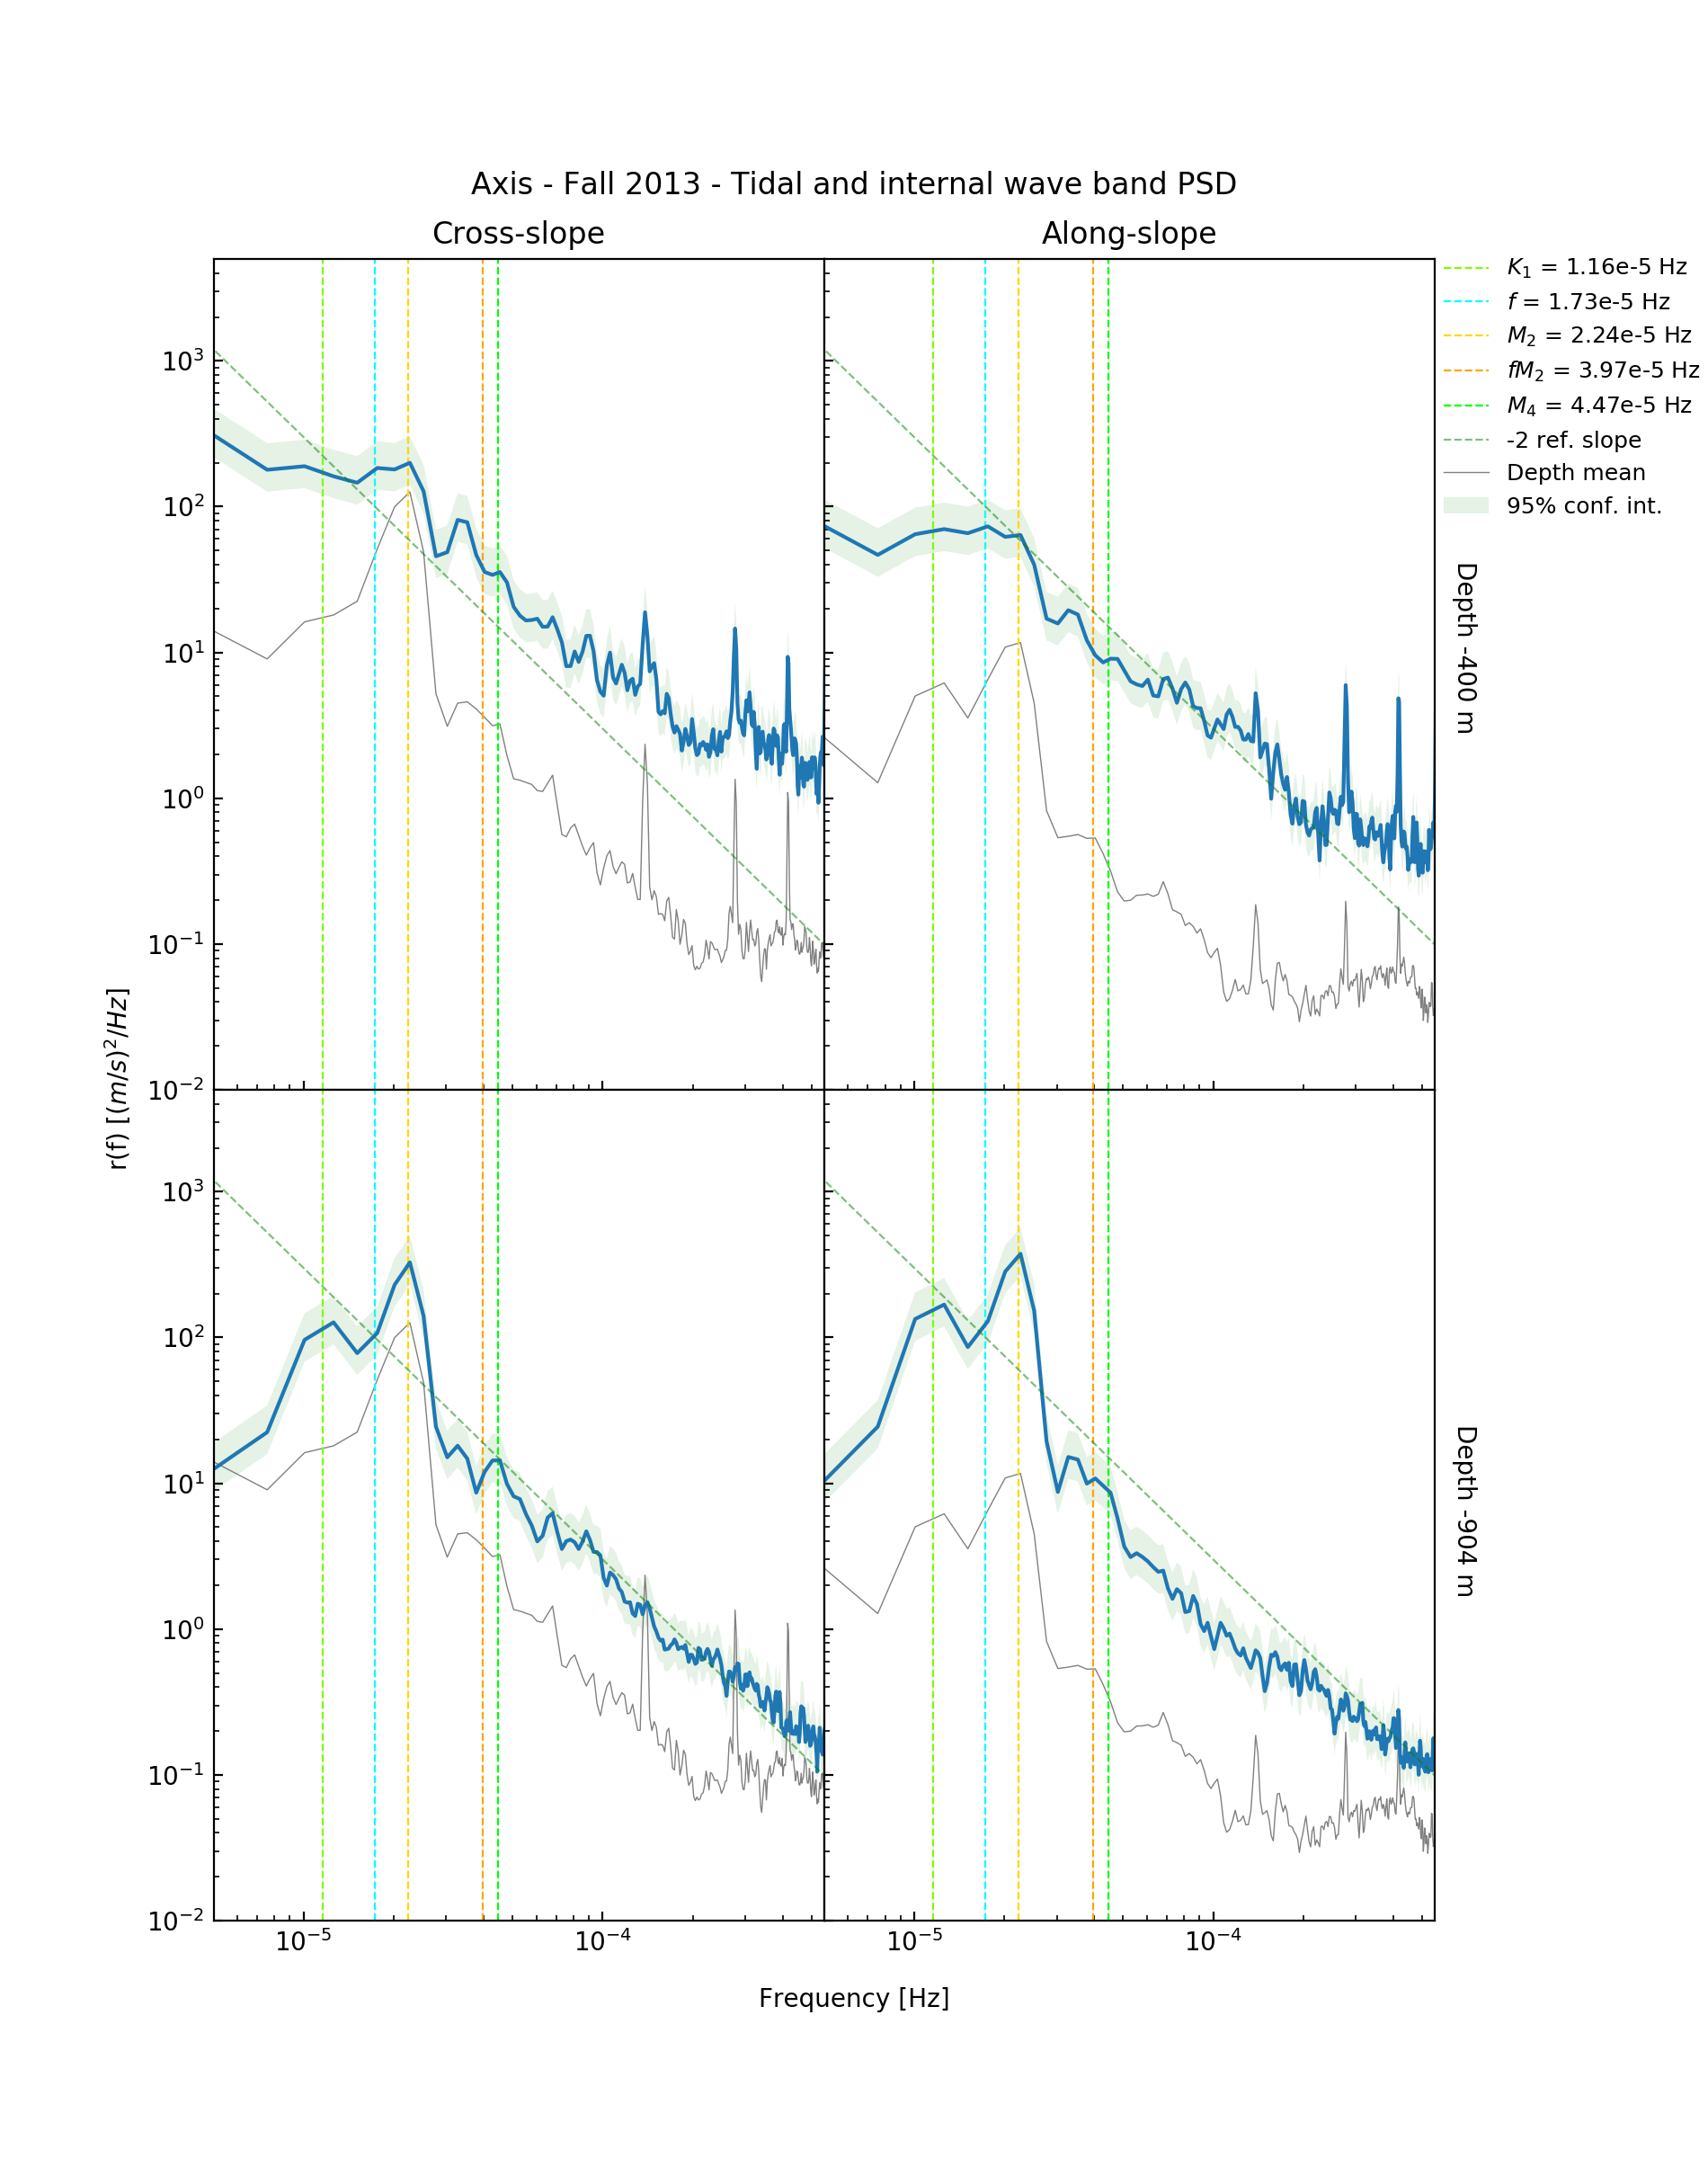

/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in power
/Users/Kurtis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in power


In [219]:
# depth comparison PSD for internal wave band

fig, axs = plt.subplots(2,2,figsize=(9.5,12), sharex=True, sharey=True)
(ax1,ax2),(ax3,ax4) = axs
fig.subplots_adjust(hspace=0, wspace=0)

ax1.loglog(um_depth_f/3600,um_depth_PSD*3600,color='gray',lw=0.5)
ax2.loglog(vm_depth_f/3600,vm_depth_PSD*3600,color='gray',lw=0.5)
ax3.loglog(um_depth_f/3600,um_depth_PSD*3600,color='gray',lw=0.5)
ax4.loglog(vm_depth_f/3600,vm_depth_PSD*3600,color='gray',lw=0.5,label='Depth mean')

ax1.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8,label = "$K_1$ = 1.16e-5 Hz") 
ax1.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8,label = "$f$ = 1.73e-5 Hz")    
ax1.axvline(2.236e-5, color ='gold',ls='--',lw=0.8,label = "$M_2$ = 2.24e-5 Hz")
ax1.axvline(3.968e-5, color ='orange',ls='--',lw=0.8,label = "$fM_2$ = 3.97e-5 Hz")
ax1.axvline(4.472e-5, color ='lime',ls='--',lw=0.8,label = "$M_4$ = 4.47e-5 Hz")
ax1.loglog(umup_f/3600, umup_PSD*3600)
ax1.tick_params(axis='both', direction='in', which='both')
#ax1.set_ylim(1e-2,8e4)   # for direct comparison between ADCP and years
ax1.set_ylim(1e-2,5e3)
ax1.set_xlim(5e-6,5.5e-4)
ax1.set_title('Cross-slope')

ax2.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8)
ax2.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8)
ax2.axvline(2.236e-5, color ='gold',ls='--',lw=0.8)
ax2.axvline(3.968e-5, color ='orange',ls='--',lw=0.8)
ax2.axvline(4.472e-5, color ='lime',ls='--',lw=0.8)
ax2.tick_params(axis='both', direction='in', which='both')
ax2.loglog(vmup_f/3600, vmup_PSD*3600)
ax2.set_title('Along-slope')

ax3.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8)
ax3.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8)
ax3.axvline(2.236e-5, color ='gold',ls='--',lw=0.8)
ax3.axvline(3.968e-5, color ='orange',ls='--',lw=0.8)
ax3.axvline(4.472e-5, color ='lime',ls='--',lw=0.8)
ax3.tick_params(axis='both', direction='in', which='both')
ax3.loglog(umlow_f/3600, umlow_PSD*3600)

ax4.axvline(1.161e-5, color ='lawngreen',ls='--',lw=0.8)
ax4.axvline(1.732e-5, color ='cyan',ls='--', lw=0.8)
ax4.axvline(2.236e-5, color ='gold',ls='--',lw=0.8)
ax4.axvline(3.968e-5, color ='orange',ls='--',lw=0.8)
ax4.axvline(4.472e-5, color ='lime',ls='--',lw=0.8)
ax4.tick_params(axis='both', direction='in', which='both')
ax4.loglog(vmlow_f/3600, vmlow_PSD*3600)

fig.text(0.85, 0.7, f'Depth {dup_stamp} m', va='center',rotation='270')
fig.text(0.85, 0.3, f'Depth {dlow_stamp} m', va='center',rotation='270')
#fig.text(0.5,0.91,f'Upper Slope - Annual {t_stamp} - Tidal and internal wave band PSD', ha='center', fontsize=12)
fig.text(0.5,0.91,f'Axis - Fall {t_stamp} - Tidal and internal wave band PSD', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'r(f) [$(m/s)^2/Hz$]', va='center', rotation='vertical')
fig.text(0.5,0.07,'Frequency [Hz]',ha='center')

ax1.fill_between(umup_f/3600, umup_lower*3600, umup_upper*3600, facecolor='green', alpha=0.1)
ax2.fill_between(vmup_f/3600, vmup_lower*3600, vmup_upper*3600, facecolor='green', alpha=0.1)
ax3.fill_between(umlow_f/3600, umlow_lower*3600, umlow_upper*3600, facecolor='green', alpha=0.1)
ax4.fill_between(vmlow_f/3600, vmlow_lower*3600, vmlow_upper*3600, facecolor='green', alpha=0.1, label='95% conf. int.')

ax1.loglog(umup_f/3600, (3e-8)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5, label='-2 ref. slope')
ax2.loglog(umup_f/3600, (3e-8)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax3.loglog(umup_f/3600, (3e-8)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
ax4.loglog(umup_f/3600, (3e-8)*(umlow_f/3600)**(-2),color='green',lw=0.8,ls='--',alpha=0.5)
#ax1.loglog(gm_freq/(2*np.pi),gm_psd*(2*np.pi),color='gray',lw=0.8,ls='--',alpha=0.5)
#ax2.loglog(gm_freq/(2*np.pi),gm_psd*(2*np.pi),color='gray',lw=0.8,ls='--',alpha=0.5)
#ax3.loglog(gm_freq/(2*np.pi),gm_psd*(2*np.pi),color='gray',lw=0.8,ls='--',alpha=0.5)
#ax4.loglog(gm_freq/(2*np.pi),gm_psd*(2*np.pi),color='gray',lw=0.8,ls='--',alpha=0.5, label='GM spectrum')

plt.subplots_adjust(right=0.84)
fig.legend(loc=(0.84,0.756), fontsize=9, frameon=False)
plt.show()

#plt.savefig(fname='./psd_plots/psd_slope_'+t_stamp+'.pdf',format='pdf')
plt.savefig(fname='./psd_plots/psd_axis_fall_'+t_stamp+'.pdf',format='pdf')

# Velocities

<IPython.core.display.Javascript object>


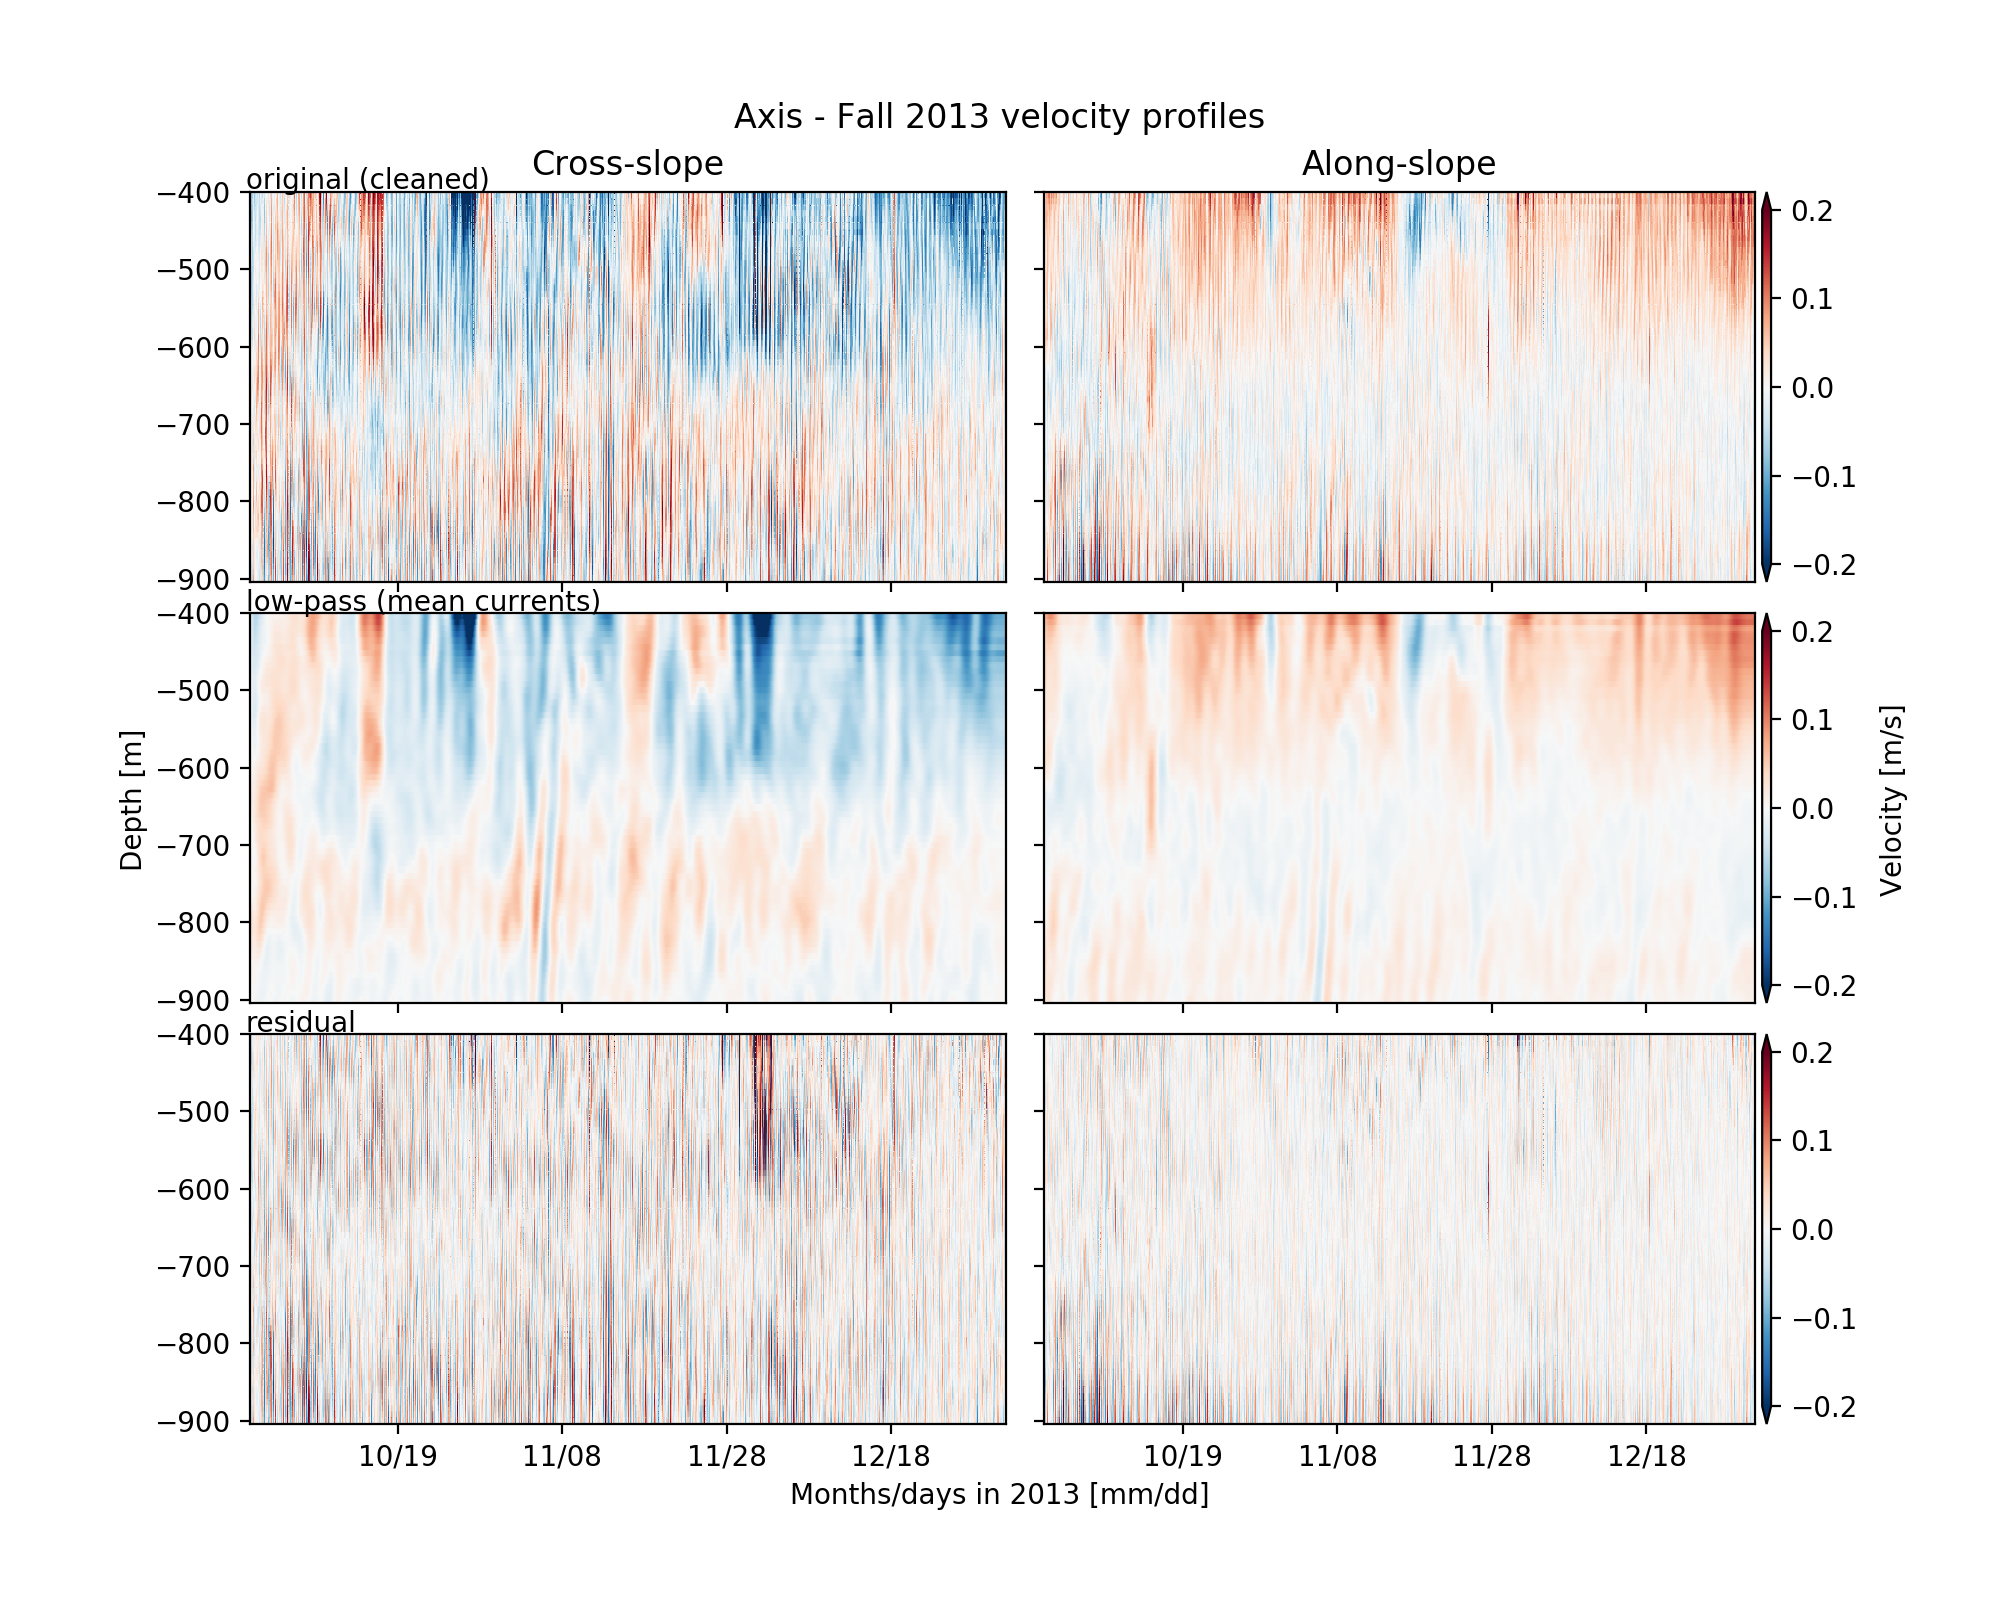

In [220]:
# plot comparative data

fig, axs = plt.subplots(3,2, figsize=(10,8), sharex = True, sharey = True)
(ax1,ax4),(ax2,ax5),(ax3,ax6) = axs
fig.subplots_adjust(hspace = 0.08,wspace = 0.05)
#fig.text(0.5, 0.92, f'Upper Slope - Annual {t_stamp} velocity profiles', ha='center', fontsize=12)
fig.text(0.5, 0.92, f'Axis - Fall {t_stamp} velocity profiles', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Depth [m]', va='center', rotation='vertical')
fig.text(0.123, 0.887, 'original (cleaned)', va='center')
fig.text(0.123, 0.623, 'low-pass (mean currents)', va='center')
fig.text(0.123, 0.360, 'residual', va='center')
fig.text(0.94, 0.5, 'Velocity [m/s]', va='center', rotation='vertical')
fig.text(0.5, 0.06, f'Months/days in {t_stamp} [mm/dd]', ha='center')
ax1.set_title('Cross-slope')
ax4.set_title('Along-slope')

im1 = ax1.pcolormesh(time, -depth, uorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
im2 = ax2.pcolormesh(time, -depth, ulp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
im3 = ax3.pcolormesh(time, -depth, uhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.20, vmax=0.20)
im4 = ax4.pcolormesh(time, -depth, vorig.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar4 = fig.colorbar(im4, ax=ax4, fraction=0.05, pad=0.01, aspect=40, extend='both')
im5 = ax5.pcolormesh(time, -depth, vlp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=40, extend='both')
im6 = ax6.pcolormesh(time, -depth, vhp.T, rasterized=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cbar6 = fig.colorbar(im6, ax=ax6, fraction=0.05, pad=0.01, aspect=40, extend='both')

date_form = pldates.DateFormatter("%m/%d")
ax6.xaxis.set_major_formatter(date_form)
ax6.set_xlim(start_date,end_date)
#ax6.set_xlim(pd.datetime(2018,1,1),pd.datetime(2019,1,1))
ax6.xaxis.set_major_locator(plt.MaxNLocator(6))

plt.show()

#plt.savefig(fname='./vel_plots/vel_slope_'+t_stamp+'.pdf',format='pdf')
plt.savefig(fname='./vel_plots/vel_axis_fall_'+t_stamp+'.pdf',format='pdf')